In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

import os
import numpy as np
import torch
from irc.manager import AgentManager

rng = np.random.default_rng()
manager = AgentManager('store', defaults='irc-defaults.yaml')

# Evaluating agent optimality

We first examine whether trained agents are optimal in their on environment. For each agent, we will find another trained one with similar discount factor $\gamma$ and entropy coefficient $\alpha_H$, and compare their return in the original environment.

In [43]:
# saved = torch.load('optimality-evaluation_diff-rates.pt')
saved = torch.load('optimality-evaluation_task-only.pt')

t_keys = saved['t_keys']
c_keys = saved['c_keys']
return_mean = saved['return_mean']
return_std = saved['return_std']

num_agents = len(c_keys)
max_steps = return_mean['t'].shape[1]-1

In [44]:
r_maxs = return_mean['t'].max(axis=1, keepdims=True)
t_return_mean = (return_mean['t']/r_maxs).mean(axis=0)
t_return_err = (return_mean['t']/r_maxs).std(axis=0)/num_agents**0.5
# t_return_err = (return_std['t']/r_maxs).mean(axis=0)/num_episodes**0.5
c_return_mean = (return_mean['c']/r_maxs).mean(axis=0)
c_return_err = (return_mean['c']/r_maxs).std(axis=0)/num_agents**0.5
# c_return_err = (return_std['c']/r_maxs).mean(axis=0)/num_episodes**0.5

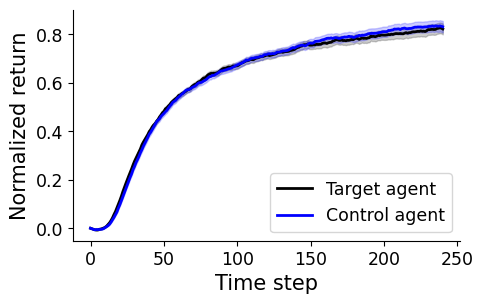

In [45]:
_, ax = plt.subplots(figsize=(5, 3))
ts = np.arange(max_steps+1)
h_t, = ax.plot(ts, t_return_mean, color='black')
ax.fill_between(ts, t_return_mean-t_return_err, t_return_mean+t_return_err, color='black', alpha=0.2)
h_c, = ax.plot(ts, c_return_mean, color='blue')
ax.fill_between(ts, c_return_mean-c_return_err, c_return_mean+c_return_err, color='blue', alpha=0.2)
ax.set_xlabel('Time step')
ax.set_ylabel('Normalized return')
ax.legend([h_t, h_c], ['Target agent', 'Control agent'], fontsize='small')
plt.show()

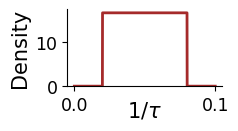

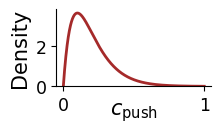

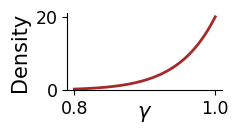

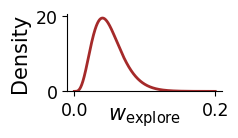

In [42]:

from scipy.stats import uniform, gamma, beta

x = np.linspace(0, 0.1, 1000)
p = uniform(1/50, 1/12.5-1/50).pdf(x)
_, ax = plt.subplots(figsize=(2, 1))
ax.plot(x, p, color='brown')
ax.set_ylim([0, None])
ax.set_xlabel(r'$1/\tau$', labelpad=-10)
ax.set_ylabel('Density')

x = np.linspace(0, 1, 1000)
p = gamma(a=2, scale=0.1).pdf(x)
_, ax = plt.subplots(figsize=(2, 1))
ax.plot(x, p, color='brown')
ax.set_ylim([0, None])
ax.set_xlabel(r'$c_\mathrm{push}$', labelpad=-10)
ax.set_ylabel('Density')

x = np.linspace(0.8, 1, 1000)
p = beta(a=20, b=1).pdf(x)
_, ax = plt.subplots(figsize=(2, 1))
ax.plot(x, p, color='brown')
ax.set_ylim([0, None])
ax.set_xlabel(r'$\gamma$', labelpad=-10)
ax.set_ylabel('Density')

x = np.linspace(0, 0.2, 1000)
p = gamma(a=5, scale=0.01).pdf(x)
_, ax = plt.subplots(figsize=(2, 1))
ax.plot(x, p, color='brown')
ax.set_ylim([0, None])
ax.set_xlabel(r'$w_\mathrm{explore}$', labelpad=-10)
ax.set_ylabel('Density')

plt.show()

# Computing heuristics for trained agents

In [98]:
min_epoch = 18
spec = 'cond-spec.yaml'
cond = manager._spec2cond(spec)
keys = [key for key, _ in manager.completed(min_epoch=min_epoch, cond=cond)]

keys = rng.choice(keys, size=(40,), replace=False)
print(f'{len(keys)} agents randomly selected.')

40 agents randomly selected.


In [99]:
from tqdm import tqdm

env_params = []
freqs = []
for key in tqdm(keys, ascii=True):
    agent, config = manager._fetch_agent_by_key(key)
    env_params.append(np.array(config.env_param))
    
    episodes = agent.run_episodes(num_episodes=5, max_steps=1200)
    move_count, push_count = 0, 0
    box_counts = [0]*3
    for episode in episodes:
        for i in range(episode.num_steps):
            if episode.infos[i+1]['pos']==episode.infos[i]['pos']:
                move_count += 1
            if episode.actions[i]==agent.model.env._push:
                push_count += 1
            for b_idx in range(3):
                if episode.infos[i+1]['pos']==agent.model.env.arena.boxes[b_idx]:
                    box_counts[b_idx] += 1
    total = sum([episode.num_steps for episode in episodes])
    freqs.append(np.array([move_count, push_count]+box_counts)/total)
env_params = np.stack(env_params)
freqs = np.stack(freqs)

100%|###################################################################################| 40/40 [09:08<00:00, 13.72s/it]


In [106]:
from hexarena.env import ForagingEnv
from hexarena.utils import load_monkey_data, discretize_monkey_data, extract_observation_action

env = ForagingEnv(arena={'resol': 2}, boxes=[{'num_grades': 10, 'num_patches': 1}]*3, dt=1)
filename = 'store/monkey-data_040523/testSession2.mat'
block_idx = 0
block_data = load_monkey_data(filename, block_idx)

env_data = discretize_monkey_data(block_data, env)
observations, actions = extract_observation_action(env_data, env)

In [121]:
freqs_monkey = []

num_segments = 10
t = len(actions)//num_segments
for k in range(num_segments):    
    freqs_monkey.append([
        ((observations[(k*t+1):((k+1)*t+1), 0]-observations[(k*t):((k+1)*t), 0])!=0).mean(),
        (actions[(k*t):((k+1)*t)]==env._push).mean(),
    ]+[(observations[(k*t):((k+1)*t), 0]==env.arena.boxes[i]).mean() for i in range(3)])
freqs_monkey = np.array(freqs_monkey)

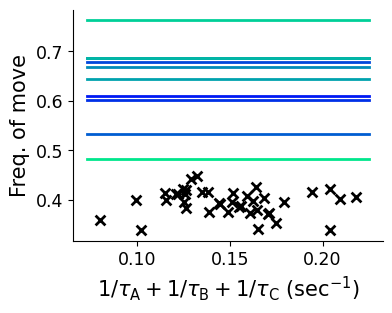

In [159]:
_, ax = plt.subplots(figsize=(4, 3))
xs = env_params[:, [4, 6, 8]].sum(axis=1)
ys = freqs[:, 0]
# xs = env_params[:, 8]
# ys = freqs[:, 4]
ax.scatter(xs, ys, s=50, marker='x', color='black')
xlim = ax.get_xlim()
for k in range(num_segments):
    ax.plot(xlim, np.ones(2)*freqs_monkey[k, 0], color=plt.colormaps.get_cmap('winter')(k/(num_segments-1)*0.8+0.1), zorder=0)
ax.set_xlabel(r'$1/\tau_\mathrm{A}+1/\tau_\mathrm{B}+1/\tau_\mathrm{C}$ ($\mathrm{sec}^{-1}$)')
ax.set_ylabel('Freq. of move')
plt.show()